# SocialBuzz Sentiment NLP
By Jonathan Nunez

# Business Understanding

WIP

Social media has become prevalant in day to day life, through daily posting of their daily lives, thoughts and opinions, as well as keeping other informed on current events. In this project the goal is to develope and train an NLP model to detect and classify the sentiment behind the post. 

# Data Understanding

WIP

The data used for this project is the [SocialBuzz Sentiment Analytics](https://www.kaggle.com/datasets/eshummalik/socialbuzz-sentiment-analytics) dataset found in [Kaggle](https://www.kaggle.com/datasets). This dataset is comprised of a little over 700 social media post, containing hastags, time posted, number of times a post was liked or retweeded, as well as the sentiment behind the post. 

In [1]:
# Importing tools and modules
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string

In [2]:
df = pd.read_csv('data/sentiment.csv')

In [3]:
df.head()

,Unnamed: 0,Unnamed: 0.1,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


In [4]:
# Dropping 'Unamed' columns
df = df.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1'])

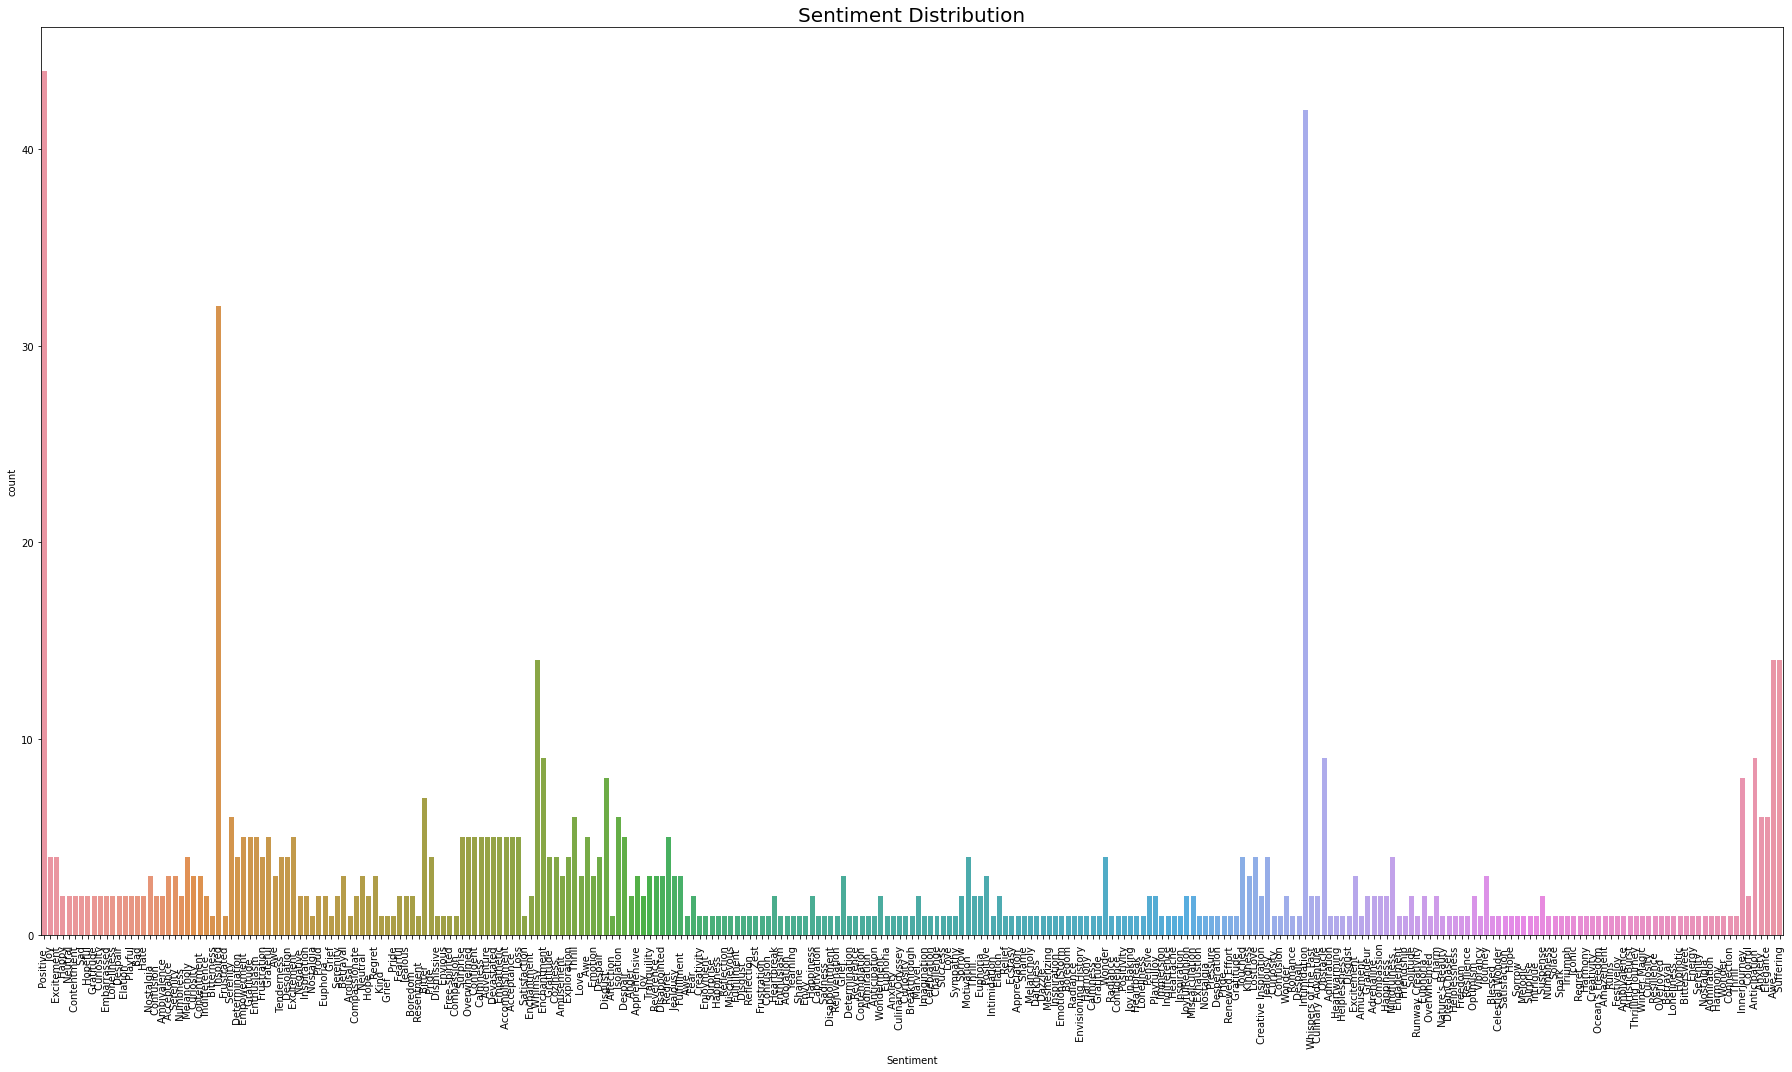

In [6]:
fig, ax = plt.subplots(figsize=(25, 15))
sn.countplot(data=df, x=df['Sentiment'])

ax.set_title('Sentiment Distribution', fontsize=20)
ax.set_xticklabels(df['Sentiment'].value_counts().index, rotation=90)
plt.tight_layout();

# Data Preparation

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Text       732 non-null    object 
 1   Sentiment  732 non-null    object 
 2   Timestamp  732 non-null    object 
 3   User       732 non-null    object 
 4   Platform   732 non-null    object 
 5   Hashtags   732 non-null    object 
 6   Retweets   732 non-null    float64
 7   Likes      732 non-null    float64
 8   Country    732 non-null    object 
 9   Year       732 non-null    int64  
 10  Month      732 non-null    int64  
 11  Day        732 non-null    int64  
 12  Hour       732 non-null    int64  
dtypes: float64(2), int64(4), object(7)
memory usage: 74.5+ KB


In [7]:
df.columns = df.columns.str.lower()

In [8]:
df['sentiment'].value_counts()

 Positive                44
 Joy                     42
 Excitement              32
 Happy                   14
 Neutral                 14
                         ..
 Runway Creativity        1
 Culinary Adventure       1
 Joy in Baking            1
 Envisioning History      1
 Heartbreak               1
Name: sentiment, Length: 279, dtype: int64

In [9]:
# Function to lowercase text
def lower_and_clean(df, columns):
    """
    This function takes in a df as well as a list of column names 
    and lowercases the string text
    
    Arg:
    df: Dataframe
    columns: A list of column names to lowercase
    """
    for col in columns:
        df[col] = df[col].str.lower()
    return df

In [10]:
to_clean = ['text', 'sentiment']

In [11]:
lower_and_clean(df, to_clean)

,text,sentiment,timestamp,user,platform,hashtags,retweets,likes,country,year,month,day,hour
0,enjoying a beautiful day at the park! ...,positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,traffic was terrible this morning. ...,negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,just finished an amazing workout! 💪 ...,positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,excited about the upcoming weekend getaway! ...,positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,trying out a new recipe for dinner tonight. ...,neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...
727,collaborating on a science project that receiv...,happy,2017-08-18 18:20:00,ScienceProjectSuccessHighSchool,Facebook,#ScienceFairWinner #HighSchoolScience,20.0,39.0,UK,2017,8,18,18
728,attending a surprise birthday party organized ...,happy,2018-06-22 14:15:00,BirthdayPartyJoyHighSchool,Instagram,#SurpriseCelebration #HighSchoolFriendship,25.0,48.0,USA,2018,6,22,14
729,successfully fundraising for a school charity ...,happy,2019-04-05 17:30:00,CharityFundraisingTriumphHighSchool,Twitter,#CommunityGiving #HighSchoolPhilanthropy,22.0,42.0,Canada,2019,4,5,17
730,"participating in a multicultural festival, cel...",happy,2020-02-29 20:45:00,MulticulturalFestivalJoyHighSchool,Facebook,#CulturalCelebration #HighSchoolUnity,21.0,43.0,UK,2020,2,29,20


# Modeling

In [12]:
X = df[['text']]
y = df['sentiment']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

In [14]:
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Evaluation

## Recomendations

## Next Steps

# Conclusion